# Classification de textes multilingue
Dans ce notebook, nous explicitons la méthode du code qui nous a permis de pré-traiter, vectoriser, et enfin classer les documents du corpus des interventions parlementaires du Parlement Européen de 1999-2004.

### Pré-traitement des corpus

Importation des bibliothèques nécessaires.

In [79]:
import numpy as np
import xml.etree.ElementTree as ET
import os
import re
from collections import defaultdict
import pandas as pd

In [2]:
def get_data(path, extensions=['.xml', '.txt']):
    '''Récupérer les listes des fichiers xml et txt'''
    file_list = []
    for dirpath, dirs, files in os.walk(path):
        for filename in files:
            name = os.path.join(dirpath, filename)
            if any(name.endswith(ext) for ext in extensions):
                file_list.append(name)
    return file_list

Nous normalisons les données et les tokenizons à l'aide la Regex que nous avons eu dans votre corrigé du premier TP. 

In [80]:
def tokenizer_and_normalizer(s):
    return [match.lower() for match in re.findall(r"\b\w+?\b(?:'|(?:-\w+?\b)*)?", s)]

Les corpus d'apprentissage et de test sont différents : tandis que les fichiers .xml du corpus d'apprentissage comprennent les interventions et les partis, le corpus de test comprend un fichier .xml avec les interventions, et un fichier texte de référence avec les partis associés. Ainsi, on définit deux parsers différents, un pour les données d'apprentissage, un pour les données test.

In [197]:
def parse_xml_train(file, dico):
    '''Parser des fichiers .xml d'entraînement.'''
    tree = ET.parse(file)
    root = tree.getroot()
    langue = file.split('_')[-1][:2]

    for i, doc in enumerate(root.findall('.//doc')):
        doc_ide = (i+1,'corpus'+  langue)
        dico[doc_ide] = {partie: [] for partie in set(partie.get('valeur') for partie in doc.findall('.//PARTI'))}
        
        texte = doc.find('.//texte')

        if texte is not None:
            for content in texte:
                if content.text is not None:
                    for partie in dico[doc_ide]:
                        dico[doc_ide][partie] += tokenizer_and_normalizer(content.text)

    return dico

def parse_xml_test(file,dico):
    '''Parser des fichiers .xml et .txt de test.'''
    tree = ET.parse(file)
    root = tree.getroot()
    langue = file.split('_')[-1][:2]
    ref_file = f'deft09/Données de référence/deft09_parlement_ref_{langue}.txt'

    dico = {}

    for doc in root.findall('.//doc'):
        doc_id = doc.get('id')
        doc_ide = (doc_id, 'corpus ' + langue)

        with open(ref_file, 'r', encoding='UTF-8') as ref:
            matching_lines = [line.split() for line in ref if line.split()[0] == doc_id]
            party = matching_lines[0][1].strip() if matching_lines and len(matching_lines[0]) > 1 else None


        party_list = dico.setdefault(doc_ide, {}).setdefault(party, [])

        texte = doc.find('.//texte')
        if texte is not None:
            for content in texte:
                if content.text is not None:
                    party_list.extend(tokenizer_and_normalizer(content.text))
    return dico

Pour une gestion plus facile des données, on transforme le dictionnaire obtenu en fichiers .csv.

In [ ]:
def create_df(dico, output_file):
    '''Transformation du dictionnaire en dataframe.
    Sauvegarde en .csv.'''
    data = [{'document': doc_ide, 'parti politique': party, 'texte': text}
            for doc_ide, parties in dico.items()
            for party, text in parties.items()]

    df = pd.DataFrame(data)

    df.to_csv(output_file, index=False, encoding='UTF8')

Nous avons pu remarqué qu'il y avait plus de lignes dans le fichier de référence test qu'il n'y avait d'interventions dans le fichier .xml. Voici une fonction qui permet de gérer ce léger problème.

In [ ]:
def remove_empty_lines(file_path):
    with open(file_path, 'r', encoding='UTF8') as file:
        lines = file.readlines()

    with open(file_path, 'w', encoding='UTF8') as file:
        for line in lines:
            if line.strip():
                file.write(line)

In [ ]:
def main():
    path_train = 'deft09/Corpus d_apprentissage'
    path_test = 'deft09/Corpus de test'

    train_files = get_data(path_train)
    test_files = get_data(path_test)

    dico_train = {}
    for file in train_files:
        dico_train.update(parse_xml_train(file, dico_train))
    create_df(dico_train, 'corpus/corpus_train.csv')
    remove_empty_lines('corpus/corpus_train.csv')

    dico_test = {}
    for file in test_files:
        dico_test.update(parse_xml_test(file, dico_test))
    create_df(dico_test, 'corpus/corpus_test.csv')
    remove_empty_lines('corpus/corpus_test.csv')

if __name__ == "__main__":
    main()

### Classification de texte
Maintenant que le corpus est pré-traité, nous pouvons passer à la vectorisation et enfin à la classification. Nous présentons les résultats obtenus avec une matrice de confusion ainsi que le rapport de classification de scikit-learn.

On réalise une validation croisée pour évaluer la robustesse du modèle multilingue. C'est le `cross_val_score` qui donne une évaluation de ce procédé. Les matrices de confusion et rapport de confusion montrés sont obtenus sans validation croisée.

Scores de validation croisée :
[0.49750473 0.50481845 0.50034417 0.50395801 0.49879539]
Précision moyenne : 0.5010841507485803
object object
Précision du modèle sur l'ensemble de test : 0.6079236030455543


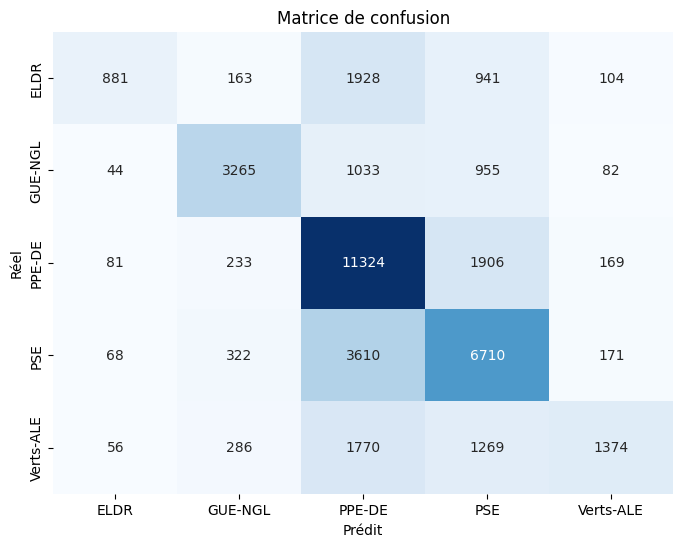

Rapport de classification :
              precision    recall  f1-score   support

        ELDR       0.78      0.22      0.34      4017
     GUE-NGL       0.76      0.61      0.68      5379
      PPE-DE       0.58      0.83      0.68     13713
         PSE       0.57      0.62      0.59     10881
   Verts-ALE       0.72      0.29      0.41      4755

    accuracy                           0.61     38745
   macro avg       0.68      0.51      0.54     38745
weighted avg       0.64      0.61      0.59     38745



In [200]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt

# ouverture des fichiers csv
train_data = pd.read_csv('corpus/corpus_train.csv')
test_data = pd.read_csv('corpus/corpus_test.csv')

train_data = train_data[train_data['parti politique'].notna()]
test_data = test_data[test_data['parti politique'].notna()]

X_train = train_data['texte']  
y_train = train_data['parti politique'] 
X_test = test_data['texte']    
y_test = test_data['parti politique'] 
y_test = y_test.astype(str)

# vectorisation avec tfidf
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# validation croisée
model = LogisticRegression(max_iter=5000, multi_class='multinomial', solver='saga')
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(model, X_train_tfidf, y_train, cv=kf, scoring='accuracy')

print("Scores de validation croisée :")
print(cross_val_scores)
print(f"Précision moyenne : {cross_val_scores.mean()}")

# entraînement du modèle sur données d'entraînement
model.fit(X_train_tfidf, y_train)
# prédictions
predictions = model.predict(X_test_tfidf)
print(y_test.dtype, predictions.dtype)

accuracy = accuracy_score(y_test, predictions)
print(f"Précision du modèle sur l'ensemble de test : {accuracy}")

# graphique : matrice de confusion
conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()

# rapport de classification
class_report = classification_report(y_test, predictions)
print("Rapport de classification :")
print(class_report)


Finalement, on réitère la même méthode mais avec l'algorithme de Random Forest.

Accuracy of the model: 0.7664576398028438


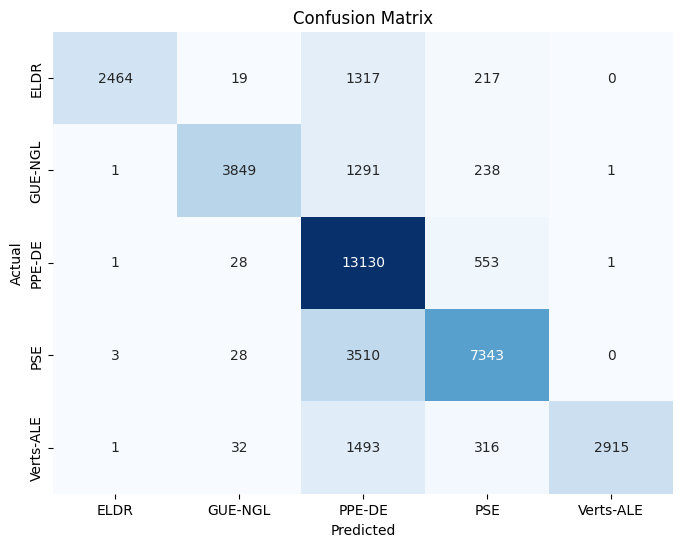

Classification Report:
              precision    recall  f1-score   support

        ELDR       1.00      0.61      0.76      4017
     GUE-NGL       0.97      0.72      0.82      5380
      PPE-DE       0.63      0.96      0.76     13713
         PSE       0.85      0.67      0.75     10884
   Verts-ALE       1.00      0.61      0.76      4757

    accuracy                           0.77     38751
   macro avg       0.89      0.71      0.77     38751
weighted avg       0.82      0.77      0.77     38751



In [86]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

# ouverture des fichiers csv
train_data = pd.read_csv('corpus/corpus_train.csv')
test_data = pd.read_csv('corpus/corpus_test.csv')

# préparations jeux train et test
train_data = train_data[train_data['parti politique'].notna()]
test_data = test_data[test_data['parti politique'].notna()]

X_train = train_data['texte']  
y_train = train_data['parti politique'] 
X_test = test_data['texte']    
y_test = test_data['parti politique'] 
y_test = y_test.astype(str)

# vectorisation
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# modèle et validation croisée
model = RandomForestClassifier(n_estimators=100, random_state=42)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(model, X_train_tfidf, y_train, cv=kf, scoring='accuracy')

print("Scores de validation croisée :")
print(cross_val_scores)
print(f"Précision moyenne : {cross_val_scores.mean()}")

# entraînement et prédiction
model.fit(X_train_tfidf, y_train)
predictions = model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy of the model: {accuracy}")

conf_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

class_report = classification_report(y_test, predictions)
print("Classification Report:")
print(class_report)
